In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
print("Initial data shape:", X_diabetes.shape, y_diabetes.shape)

# Convert the target to binary for classification
threshold = y_diabetes.mean()
y_diabetes_binary = (y_diabetes > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_diabetes_binary[:10])

# Train-test split for regression and classification
data_split = train_test_split(
    X_diabetes, y_diabetes, y_diabetes_binary, test_size=0.2, random_state=42
)
X_train_d, X_test_d, y_train_d, y_test_d, y_train_d_binary, y_test_d_binary = data_split
print("Train/Test split shapes:", X_train_d.shape, X_test_d.shape)

# Standardize features
scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)
print("Sample standardized features (first 5 rows):", X_train_d[:5])

# Convert to PyTorch tensors
X_train_d_tensor = torch.tensor(X_train_d, dtype=torch.float32).to(device)
X_test_d_tensor = torch.tensor(X_test_d, dtype=torch.float32).to(device)
y_train_d_tensor = torch.tensor(y_train_d, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_tensor = torch.tensor(y_test_d, dtype=torch.float32).view(-1, 1).to(device)
y_train_d_binary_tensor = torch.tensor(y_train_d_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_binary_tensor = torch.tensor(y_test_d_binary, dtype=torch.float32).view(-1, 1).to(device)

Initial data shape: (442, 10) (442,)
Threshold for classification: 152.13348416289594
Binary target values (first 10): [0 0 0 1 0 0 0 0 0 1]
Train/Test split shapes: (353, 10) (89, 10)
Sample standardized features (first 5 rows): [[ 1.49836523  1.06136988  0.21990201  1.13887373  0.72847289  1.05589332
  -0.82445065  0.71103773  0.54748197 -0.06144896]
 [-0.22885822  1.06136988 -0.41936607 -0.71059105 -0.4249289   0.27242452
  -1.52979055  1.4842858  -0.01975653  0.36723647]
 [ 0.08518241 -0.94217861  1.01898711  1.99247286 -0.30958872 -0.32669867
  -0.11911075 -0.06221033  0.3312366  -0.31866022]
 [-0.621409   -0.94217861 -0.78466212 -0.63945779 -1.17464007 -1.21550781
   0.66460025 -0.83545839 -1.06968217 -2.71929861]
 [-0.54289885 -0.94217861 -1.4239302  -1.7064567  -0.79978448 -1.11016747
   1.29156905 -1.60870645 -0.80285867 -0.91881982]]


In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

# Initialize models
model_regression = FeedforwardNN(X_train_d.shape[1], 1).to(device)
model_classification = FeedforwardNN(X_train_d.shape[1], 1).to(device)
print("Models initialized.")

Models initialized.


In [ ]:
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.01)
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.01)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


In [ ]:
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        inputs = X_train
        targets = y_train

        # Forward pass
        predictions = model(inputs, classification=classification)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Train the Regression model
print("Training Regression Model")
train_model(model_regression, optimizer_regression, X_train_d_tensor, y_train_d_tensor, criterion_regression)

# Train the Classification model
print("Training Classification Model")
train_model(model_classification, optimizer_classification, X_train_d_tensor, y_train_d_binary_tensor, criterion_classification, classification=True)

Training Regression Model
Epoch 10/100, Loss: 27891.5176
Epoch 20/100, Loss: 19192.3418
Epoch 30/100, Loss: 6714.4658
Epoch 40/100, Loss: 5927.4023
Epoch 50/100, Loss: 4493.7925
Epoch 60/100, Loss: 3680.8486
Epoch 70/100, Loss: 3320.2817
Epoch 80/100, Loss: 3086.5203
Epoch 90/100, Loss: 2937.7849
Epoch 100/100, Loss: 2836.8286
Training Classification Model
Epoch 10/100, Loss: 0.4883
Epoch 20/100, Loss: 0.4426
Epoch 30/100, Loss: 0.4099
Epoch 40/100, Loss: 0.3624
Epoch 50/100, Loss: 0.3011
Epoch 60/100, Loss: 0.2217
Epoch 70/100, Loss: 0.1381
Epoch 80/100, Loss: 0.0738
Epoch 90/100, Loss: 0.0409
Epoch 100/100, Loss: 0.0217


Regression predictions (first 5): [167.49629 185.82825 148.65697 322.9447   85.3622 ]
Regression Model - MSE: 2911.0679, R-squared: 0.4506
Classification predictions (first 5): [False  True  True  True False]
Classification Model - Accuracy: 0.7865


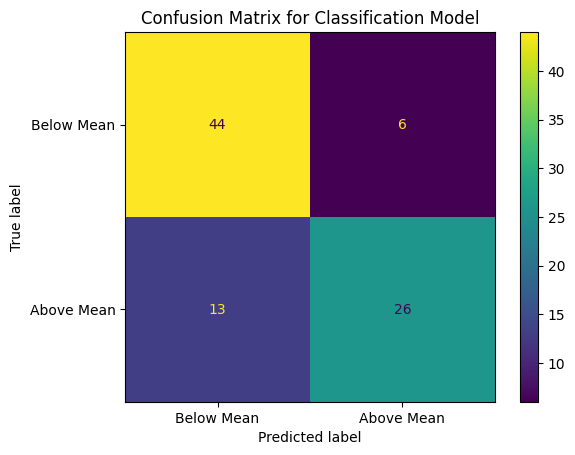

In [ ]:
def evaluate_model_regression(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)
        r2 = r2_score(y_test.cpu().numpy(), predictions)
        print("Regression predictions (first 5):", predictions[:5].flatten())
    return mse, r2

def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, cm

# Evaluate the Regression model
mse_d, r2_d = evaluate_model_regression(model_regression, X_test_d_tensor, y_test_d_tensor)
print(f"Regression Model - MSE: {mse_d:.4f}, R-squared: {r2_d:.4f}")

# Evaluate the Classification model
accuracy_d, cm_d = evaluate_model_classification(model_classification, X_test_d_tensor, y_test_d_binary_tensor)
print(f"Classification Model - Accuracy: {accuracy_d:.4f}")

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Below Mean", "Above Mean"]).plot()
plt.title("Confusion Matrix for Classification Model")
plt.show()

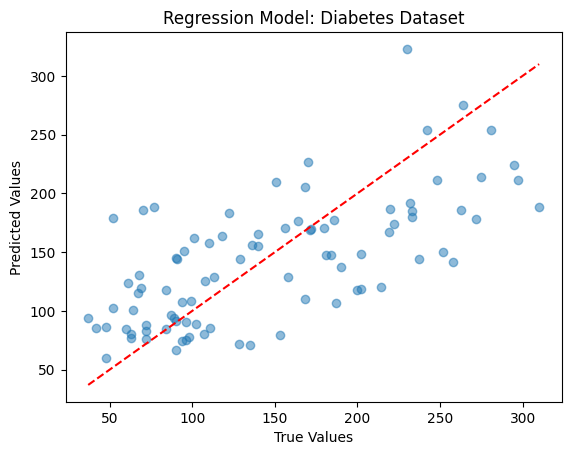

In [ ]:
def plot_results_regression(y_test, predictions, title):
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Visualize results for the Regression model
with torch.no_grad():
    predictions_d = model_regression(X_test_d_tensor).cpu().numpy()
    plot_results_regression(y_test_d_tensor.cpu().numpy(), predictions_d, "Regression Model: Diabetes Dataset")